STATIONARY TESTS TIME SERIES FOR FRESNO DATA

## Acquire Data

In [230]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller


In [231]:
filename = "data/ac_output.csv"
output = pd.read_csv(filename)
output.head()



,datetime,0
0,1998-01-01 00:00:00,36.03534
1,1998-01-01 00:30:00,-1.15500
2,1998-01-01 01:00:00,-1.15500
3,1998-01-01 01:30:00,-1.15500
4,1998-01-01 02:00:00,-1.15500


In [232]:
output.index = pd.to_datetime(output['datetime'])
daily_output = output['0'].resample('W').sum()
#daily_output.to_csv('daily_output.csv')
daily_output = daily_output.reset_index()
daily_output.columns = ['datetime', 'initial']

date = pd.DataFrame(daily_output['datetime'])

## Stationary Tests


Augmented Dickey-Fuller Test:
Test Statistic: -10.5565
p-value: 0.0000
Critical Values:
	1%: -3.4355
	5%: -2.8638
	10%: -2.5680

KPSS Test:
Test Statistic: 0.0458
p-value: 0.1000


C:\Users\naoki\AppData\Local\Temp\ipykernel_24172\2127803509.py:47: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(timeseries.dropna())


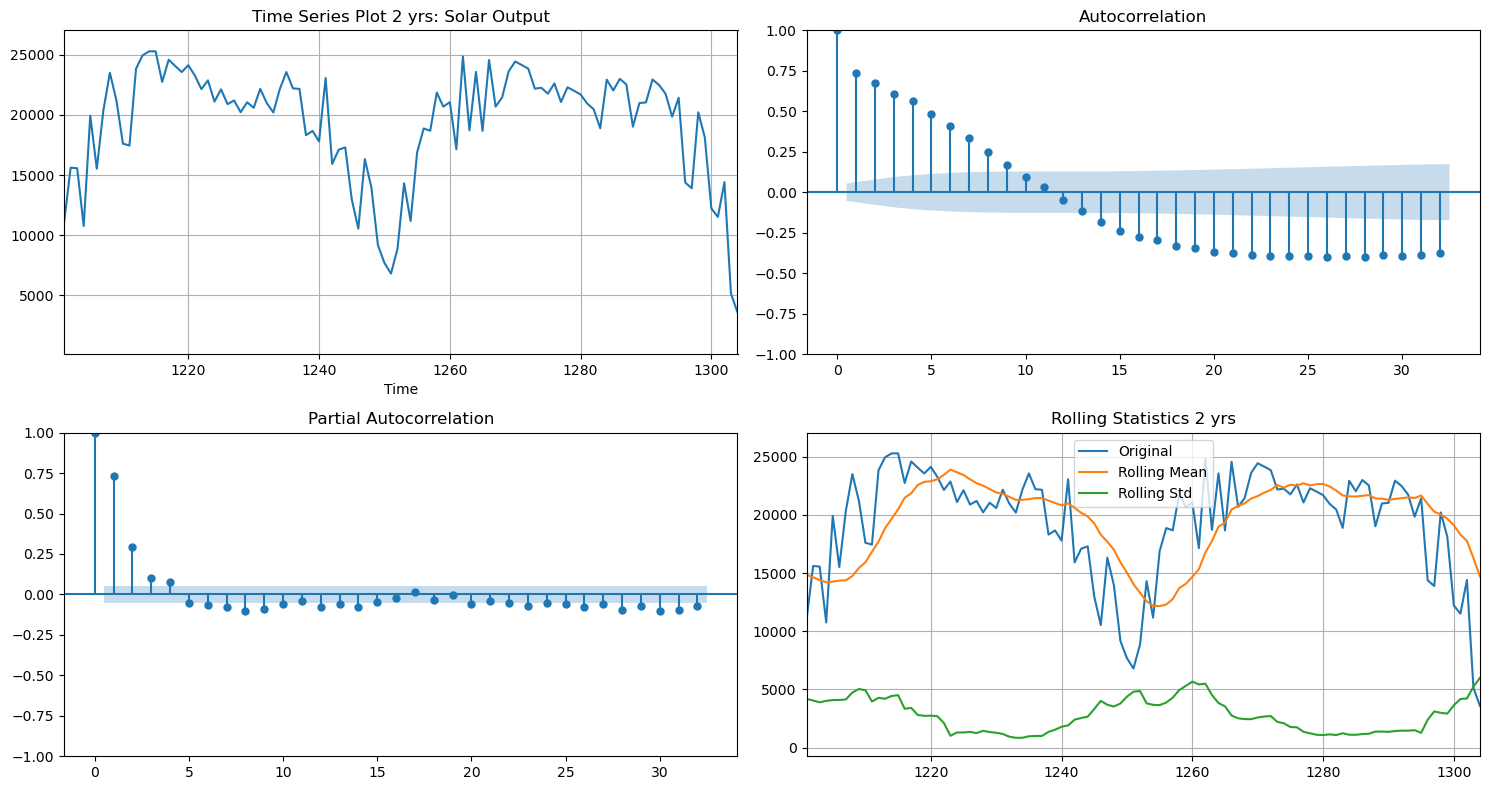

In [233]:

import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def check_stationarity(timeseries, title=''):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 8))
    
    # Time series plot
    ax1.plot(timeseries)
    ax1.set_title(f'Time Series Plot 2 yrs: {title}')
    ax1.set_xlabel('Time')
    ax1.set_xlim([timeseries.index[-104], timeseries.index[-1]])
    ax1.grid(True)
    
    # ACF plot 
    plot_acf(timeseries, ax=ax2, title='Autocorrelation')
      
    
    # PACF plot 
    plot_pacf(timeseries, ax=ax3, title='Partial Autocorrelation')
      
    
    # Rolling statistics
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()
    ax4.plot(timeseries, label='Original')
    ax4.plot(rolling_mean, label='Rolling Mean')
    ax4.plot(rolling_std, label='Rolling Std')
    ax4.set_title('Rolling Statistics 2 yrs')
    ax4.legend()
    ax4.set_xlim([timeseries.index[-104], timeseries.index[-1]])
    ax4.grid(True)
    
    plt.tight_layout()
    
    # ADF Test
    adf_result = adfuller(timeseries.dropna())
    print('\nAugmented Dickey-Fuller Test:')
    print(f'Test Statistic: {adf_result[0]:.4f}')
    print(f'p-value: {adf_result[1]:.4f}')
    print('Critical Values:')
    for key, value in adf_result[4].items():
        print(f'\t{key}: {value:.4f}')
    
    # KPSS Test
    kpss_result = kpss(timeseries.dropna())
    print('\nKPSS Test:')
    print(f'Test Statistic: {kpss_result[0]:.4f}')
    print(f'p-value: {kpss_result[1]:.4f}')


check_stationarity(daily_output['initial'], 'Solar Output')


Dickey Fuller Test Findings: Reject Null hypothesis of non-stationarity. 



Time Series Plot findings: Seasonal patterns. 

ACF Plot findings : Strong positive 1st lag Autocorrelation, medium strength long term autocorrelations . Slow decay = non-stationary

PACF Plot findings: Strong short term autocorrelation

Rolling Statistics Plot Findings: Std significantly rises during winter months. Variation is seasonality. Need for GARCH model



## Transformation of data to stationary

Data Follows yearly seasonal pattern. Difference by 1 year and 1 period.
APPLY DIFFERENCING 2nd order

In [234]:
daily_output['1pd'] = daily_output['initial'].diff(periods=1)
daily_output['seasonal'] = daily_output['initial'].diff(periods=52)


daily_output['differenced'] = daily_output['initial'].diff(periods=52)
daily_output['differenced'] = daily_output['differenced'].diff(periods=1)

<Axes: >

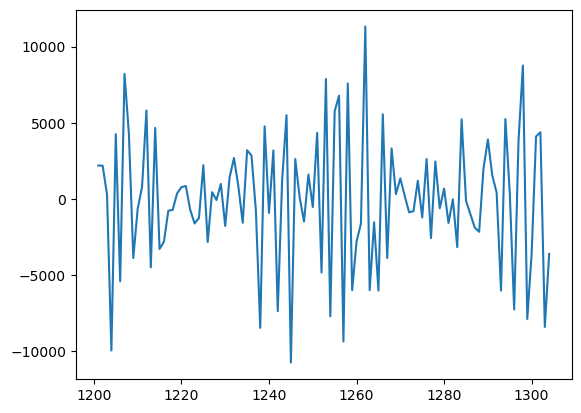

In [235]:
daily_output['differenced'][-104:].plot()

2 Yrs of 2 differenced plot

## Test For Stationarity AGAIN


Augmented Dickey-Fuller Test:
Test Statistic: -12.3115
p-value: 0.0000
Critical Values:
	1%: -3.4357
	5%: -2.8639
	10%: -2.5680

KPSS Test:
Test Statistic: 0.0272
p-value: 0.1000


C:\Users\naoki\AppData\Local\Temp\ipykernel_24172\2127803509.py:47: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(timeseries.dropna())


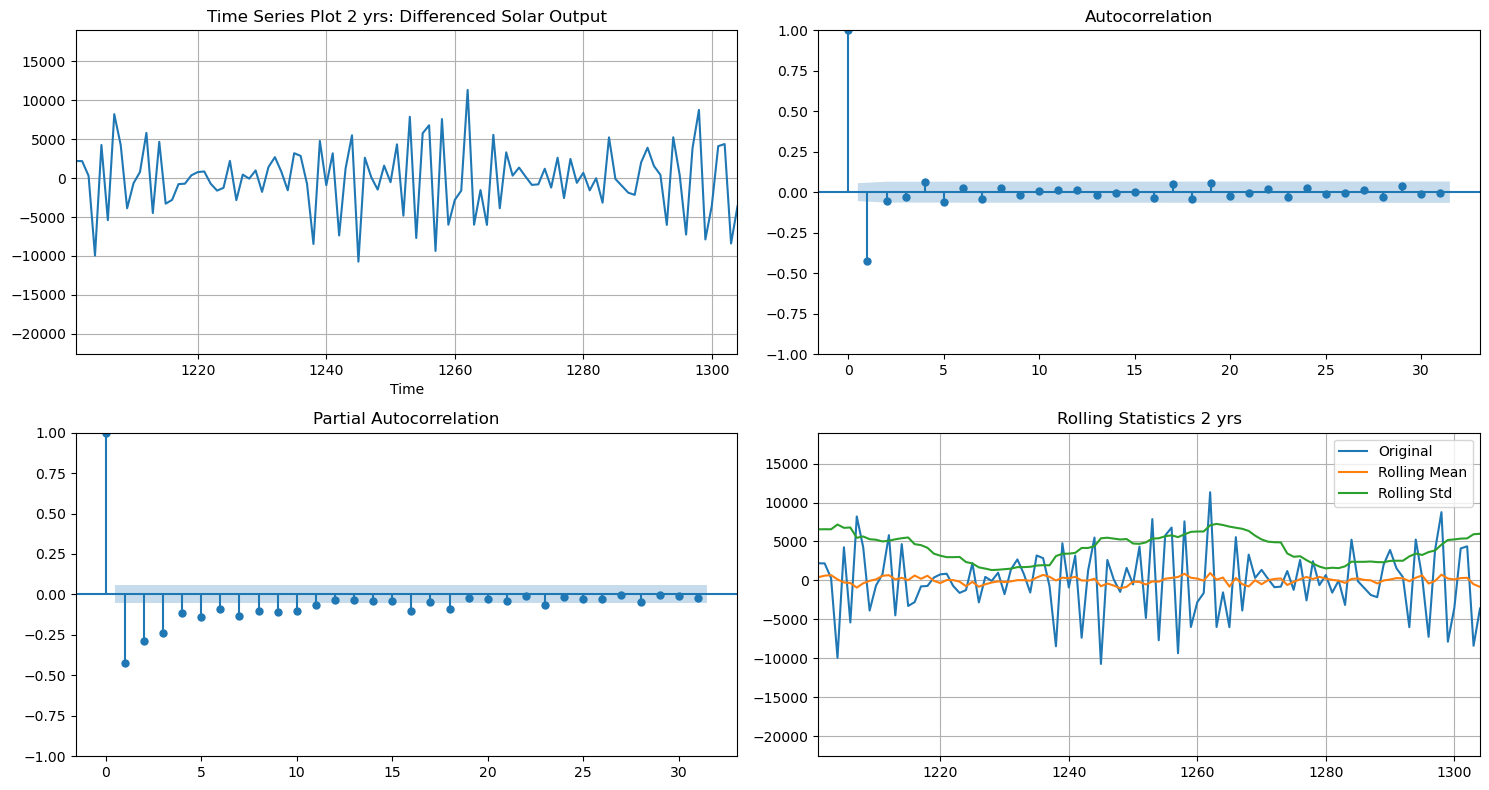

In [236]:
check_stationarity(daily_output['differenced'].dropna(), 'Differenced Solar Output')

Autocorrelations now mostly stay inside of confidence intervals. Suggests no reason to reject Null

## Decomposition of line----supplementary analysis


In [237]:
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


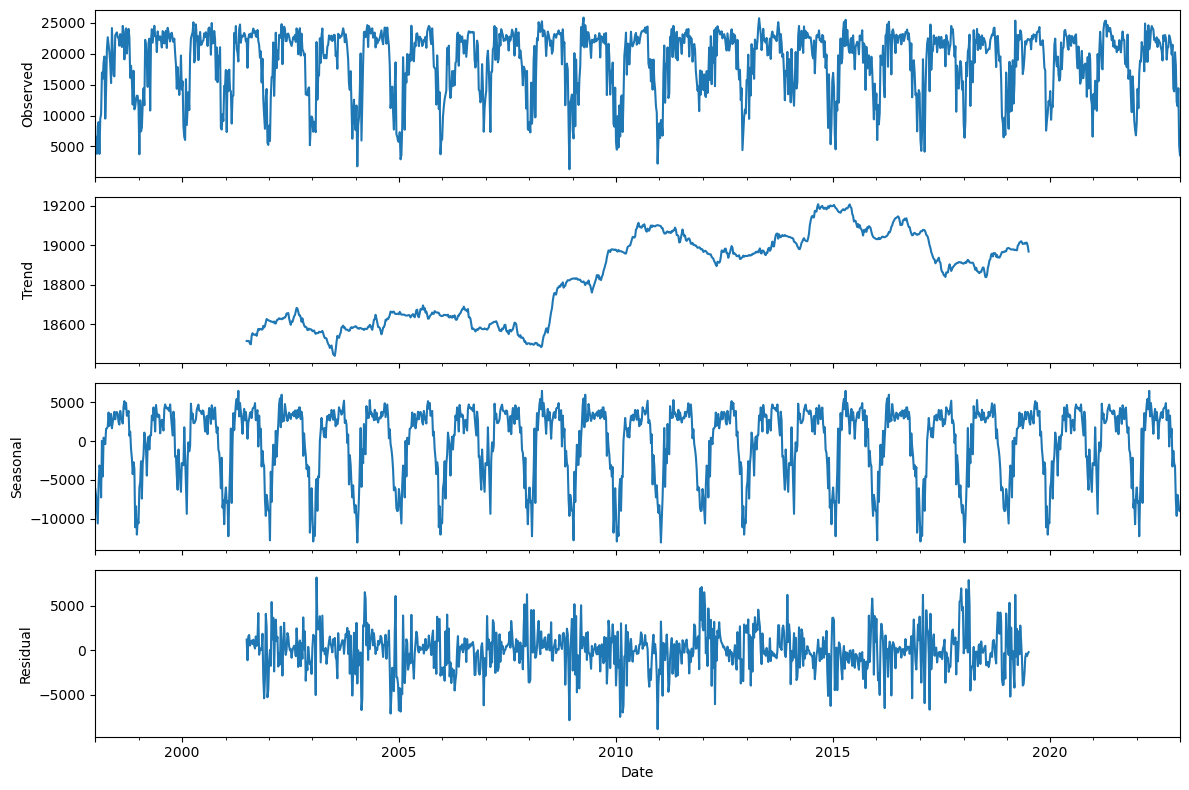

In [238]:
WINDOW_SIZE = 365   

result = seasonal_decompose(daily_output['initial'], model='additive', period=WINDOW_SIZE)
daily_output['Residual'] = result.resid
# Set the datetime index for the decomposed components
result.trend.index = daily_output['datetime']
result.seasonal.index = daily_output['datetime']
result.resid.index = daily_output['datetime']
result.observed.index = daily_output['datetime']

# Plot the decomposed components with dates on the x-axis
fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)
result.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')
result.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')
result.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
result.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual')
axes[3].set_xlabel('Date')
plt.tight_layout()


C:\Users\naoki\AppData\Local\Temp\ipykernel_24172\4288516415.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result.trend[daily_output_2010.index].plot(ax=axes[1], legend=False)
C:\Users\naoki\AppData\Local\Temp\ipykernel_24172\4288516415.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result.seasonal[daily_output_2010.index].plot(ax=axes[2], legend=False)
C:\Users\naoki\AppData\Local\Temp\ipykernel_24172\4288516415.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To acce

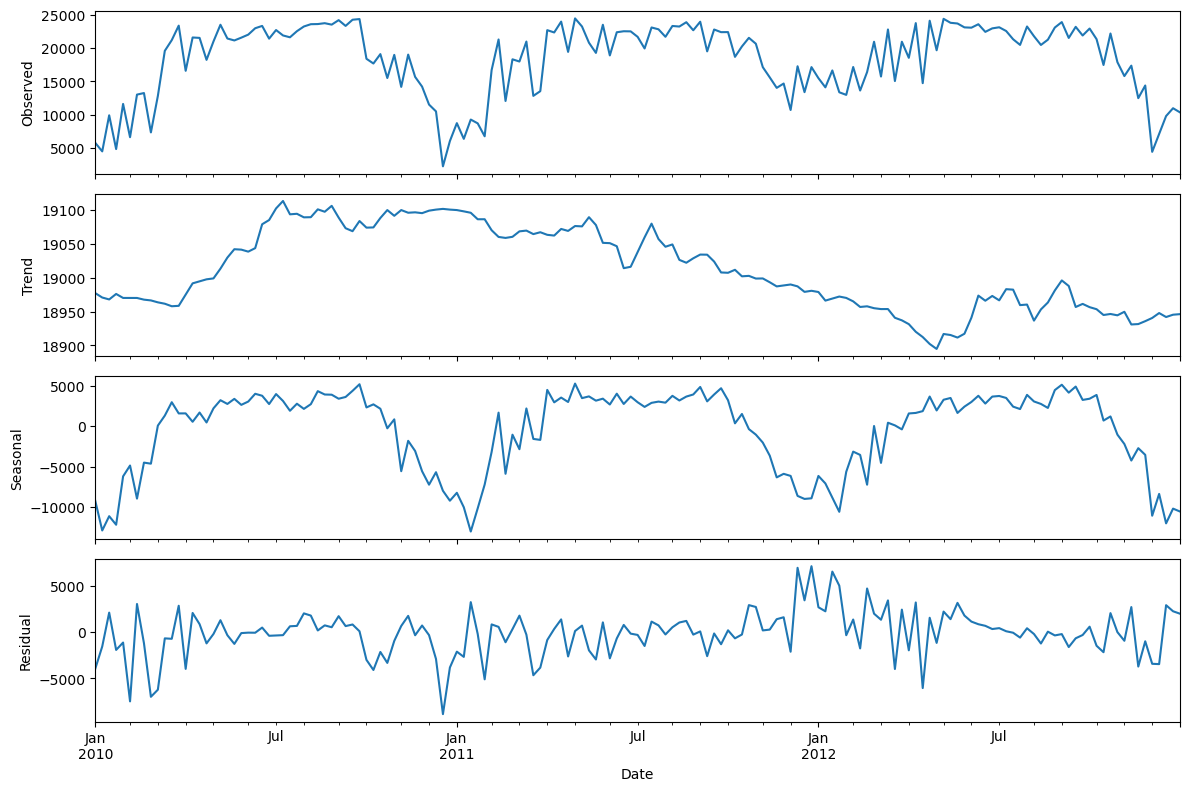

In [239]:
# Filter data for the year 2010
daily_output_2010 = daily_output[(daily_output['datetime'] >= '2010-01-01') & (daily_output['datetime'] <= '2012-12-31')]

# Plot the decomposed components for the year 2010
fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)
daily_output_2010.set_index('datetime')['initial'].plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')
result.trend[daily_output_2010.index].plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')
result.seasonal[daily_output_2010.index].plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
result.resid[daily_output_2010.index].plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual')
axes[3].set_xlabel('Date')
plt.tight_layout()
plt.show()

We see it isolates a clear seasonal component but also that the residuals are autocorrelated and skewed

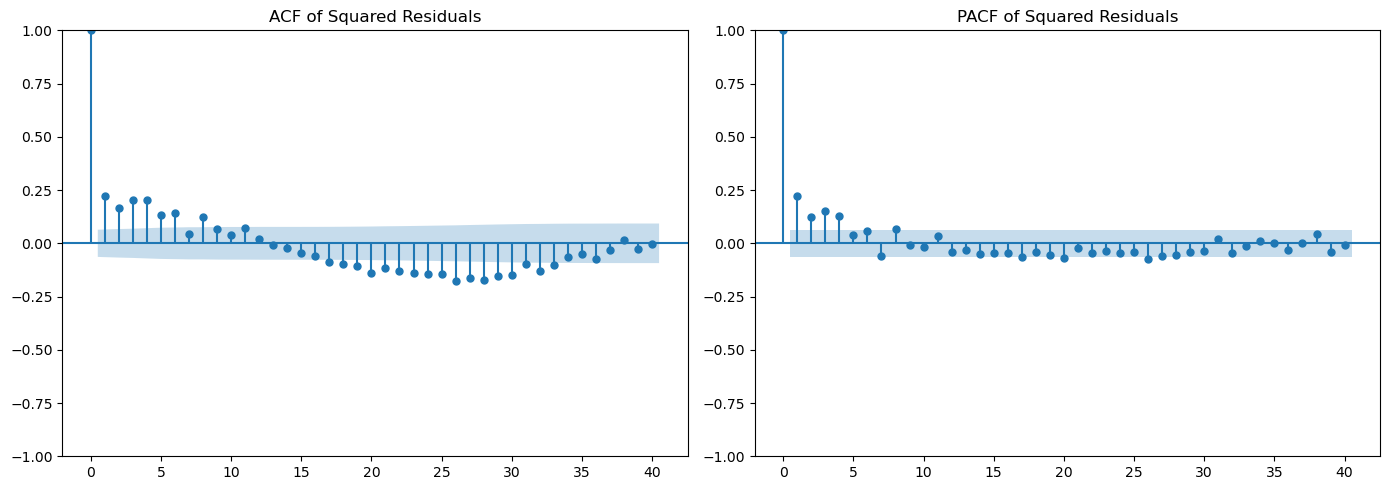

In [240]:
residuals_no_nan = daily_output['Residual'].dropna()

# Calculate squared residuals
squared_residuals = residuals_no_nan**2

# Plot ACF and PACF of squared residuals
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

plot_acf(squared_residuals, lags=40, ax=axes[0])
axes[0].set_title('ACF of Squared Residuals')

plot_pacf(squared_residuals, lags=40, ax=axes[1])
axes[1].set_title('PACF of Squared Residuals')

plt.tight_layout()
plt.show()

Interpreting the Plots:

- ACF of Squared Residuals:
   - Significant Autocorrelations: If you see significant autocorrelations (bars extending beyond the shaded confidence interval) in the ACF of the squared residuals, it indicates that there is heteroscedasticity (changing variance) in the residuals. The lags at which these significant autocorrelations occur suggest the order of the ARCH component (p) in a GARCH model.  From the plot it is clear that the squared residuals are correlated with their past values, meaning that periods of high volatility are likely to be followed by periods of high volatility, and vice-versa.

    

- PACF of Squared Residuals:
   - Significant Partial Autocorrelations: Similar to the ACF, significant partial autocorrelations in the PACF of the squared residuals also indicate heteroscedasticity. The PACF helps to determine the order of the GARCH component (q) in a GARCH model. In the plot we see significant partial autocorrelations primarily at lags 1, 2, 3, and 4. This further confirms the presence of heteroscedasticity. Pattern: The PACF, like the ACF, also shows a few significant lags and then a relatively quick decay. 

This justifies using a GARCH model.





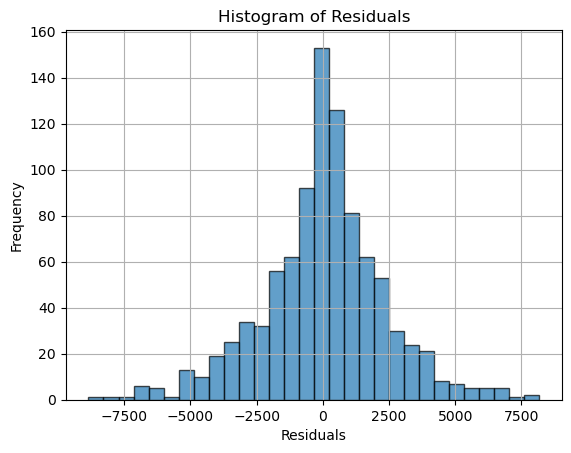

In [241]:
plt.hist(residuals_no_nan, bins=30, edgecolor='k', alpha=0.7)
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

## Data preprocess

SCALE DATA (Z-score normalization)

In [242]:
from sklearn.preprocessing import StandardScaler

In [188]:

data = pd.DataFrame()
data['input'] = daily_output['differenced'][53:]
data.index = date['datetime'][53:]


,input,input_zscore
datetime,,
1999-01-10,-6344.466729,-1.185819
1999-01-17,15244.376213,2.852499
1999-01-24,-6931.402623,-1.295609
1999-01-31,2953.051975,0.553335
1999-02-07,7622.320670,1.426749
...,...,...
2022-12-04,-2397.348652,-0.447488
2022-12-11,-2664.276674,-0.497418
2022-12-18,2839.105135,0.532021


TEST AND TRAIN SPLIT

In [207]:
scaler = StandardScaler()
train_size = int(len(data) -52)
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

NameError: name 'StandardScaler' is not defined

CONVERT TO 32bit float for RAM saving

In [194]:
input = train_data['input_zscore'].astype(np.float32)

## Fitting SARIMAX model

In [195]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm

In [196]:
model = SARIMAX(input, 
                order=(1, 1, 0), 
                seasonal_order=(0, 1, 0, 52), 
                enforce_stationarity=True,
                force_invertibility=False)
results = model.fit()

c:\Users\naoki\miniforge3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\naoki\miniforge3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\naoki\miniforge3\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['force_invertibility']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


## ANALYZING Results

In [197]:
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                       input_zscore   No. Observations:                 1200
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 52)   Log Likelihood               -2260.547
Date:                            Mon, 23 Dec 2024   AIC                           4525.095
Time:                                    16:14:22   BIC                           4535.184
Sample:                                01-10-1999   HQIC                          4528.904
                                     - 01-02-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6430      0.021    -30.334      0.000      -0.685      -0.601
sigma2         3.0141      0.109   

In [198]:
in_sample_pred = results.predict(start=1, end=len(data))

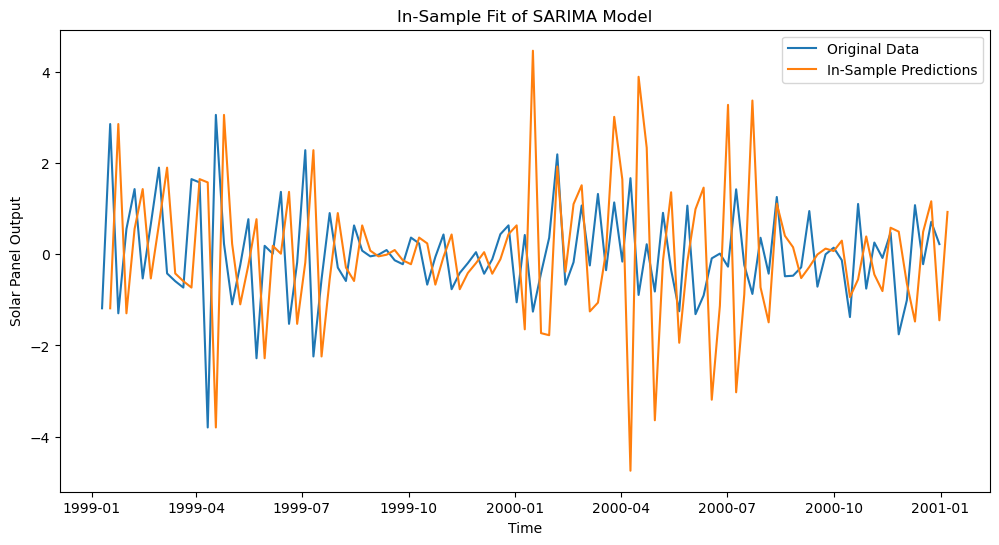

In [199]:
plt.figure(figsize=(12, 6))
plt.plot(data['input_zscore'][:104], label='Original Data')
plt.plot(in_sample_pred[:104], label='In-Sample Predictions')
plt.xlabel('Time')
plt.ylabel('Solar Panel Output')  # Replace with your actual variable name
plt.title('In-Sample Fit of SARIMA Model')
plt.legend()
plt.show()

In [206]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
forecast = results.get_forecast(steps=52)
mae = mean_absolute_error(test_data['input_zscore'], forecast.predicted_mean)
mse = mean_squared_error(test_data['input_zscore'], forecast.predicted_mean)
print(f'Mean Absolute Error: {mae:.4f}')
print(f'Mean Squared Error: {mse:.4f}')

Mean Absolute Error: 0.9691
Mean Squared Error: 1.4204


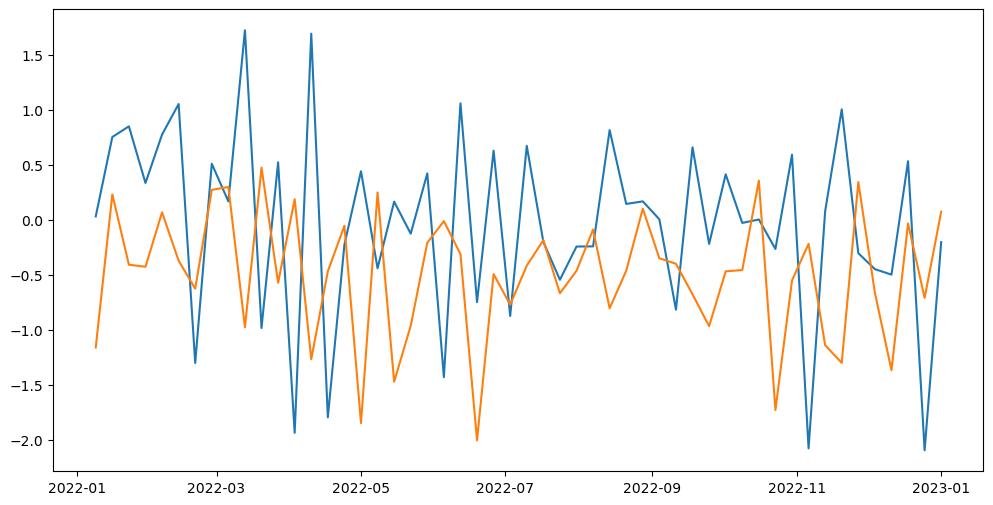

In [204]:
plt.figure(figsize=(12, 6))
plt.plot(test_data['input_zscore'], label='Original Data')
plt.plot(forecast.predicted_mean, label='Forecast')